In [83]:
# calculate annual total emission from terrestrial exchange

In [84]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [85]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from util.functions import area_latlon
from util.gamap_colormap import WhGrYlRd

In [86]:
# Terrestrial, GEOS-Chem default
input_dir = '/geos/d21/GC_DATA/ExtData/HEMCO/'
fname = 'CO2/v2015-04/BIO/Net_terrestrial_exch_5.29Pg.generic.1x1.nc'
ds_ter  = xr.open_dataset(input_dir+fname)

# year 2000, annual mean
lat_res = ds_ter.attrs['Delta_Lat']
lon_res = ds_ter.attrs['Delta_Lon']
varname = 'CO2'
unit    = ds_ter[varname].attrs['units']
ds_ter['CO2']

<xarray.DataArray 'CO2' (time: 1, lat: 180, lon: 360)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 2000-01-01
Attributes:
    long_name:  CO2
    units:      kg/m2/s

In [87]:
dr_gc = ds_ter[varname][0,:,:].copy()

In [88]:
ts_us = dr_gc.sel(lon = -91, lat = 37.7, method = 'nearest')
print(ts_us)


<xarray.DataArray 'CO2' ()>
array(-1.182622e-08, dtype=float32)
Coordinates:
    lon      float64 -90.5
    lat      float32 37.5
    time     datetime64[ns] 2000-01-01
Attributes:
    long_name:  CO2
    units:      kg/m2/s


In [89]:
# sum up global total
for ilat, lat in enumerate(dr_gc.lat):
    area_tmp = area_latlon(lat1 = lat, 
                            lon1 = dr_gc.lon[10].values, 
                            lat2 = lat + lat_res, 
                            lon2 = dr_gc.lon[10].values + lon_res)
    dr_gc[ilat,:] = dr_gc[ilat,:] * area_tmp *3600*24*366*1e6 # unit: kgCO2/yr
gc_total_original = dr_gc.copy() # plot later, kgCO2/yr/grid cell
total = dr_gc.sum()   # kgCO2/year, same as data description
ann_total = total.values  # kg/yr
ann_total_C_original = total.values*1e-12*12/44  # GtC/yr
    
print('annual total from this calculation:')
print(' ',ann_total_C_original)
print(' ')

annual total from this calculation:
  -5.269060654917819
 


In [90]:
#  Liang, CASA 3 hourly
input_dir = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2020-04/'
fname     = 'NEE.3hrly.1x1.25.2016.nc'
ds_liang  = xr.open_dataset(input_dir+fname)
ds_liang # 2016

lat_res = 1.
lon_res = 1.25
varname = 'NEE'

dr_liang = ds_liang[varname].copy()
ds_liang

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 288, t-3hr: 2928)
Coordinates:
  * lon      (lon) float32 -180.0 -178.75 -177.5 -176.25 ... 176.25 177.5 178.75
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
Dimensions without coordinates: t-3hr
Data variables:
    NEE      (t-3hr, lat, lon) float32 ...
Attributes:
    flux_variable_description:  Net Ecosystem Exchange
    CO2_flux_sign:              +: emission to atmosphere; -: uptake from atm...
    Time_Interval:              3-hours, mid-point

-1.1798799385900241e-09


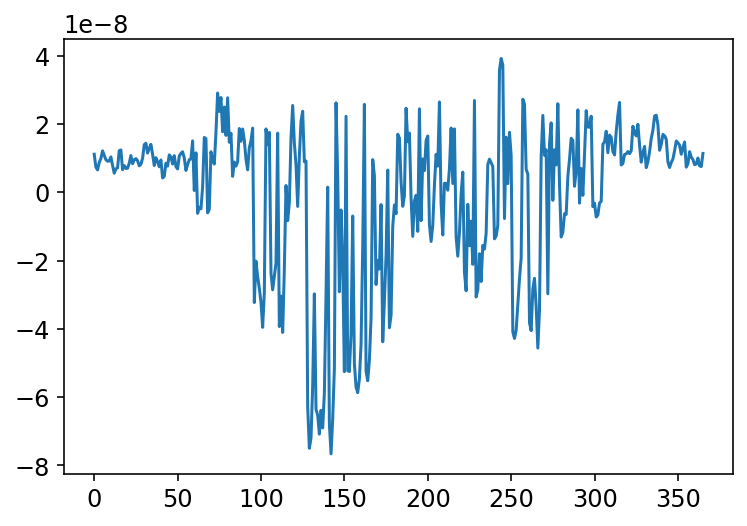

In [91]:
ts_us = dr_liang.sel(lon = -91, lat = 37.7, method = 'nearest')
#plt.plot(ts_us[0:16])
ts_daily  = np.zeros(366) # store daily mean

for iday in range(366):
    ts_daily[iday] = np.mean(ts_us[(iday*8):((iday+1)*8-1)])
plt.plot(ts_daily)
print(ts_daily.mean())

In [92]:

for ilat, lat in enumerate(dr_liang.lat):
    area_tmp = area_latlon(lat1 = lat, 
                           lon1 = dr_liang.lon[10].values, 
                           lat2 = lat + lat_res, 
                           lon2 = dr_liang.lon[10].values + lon_res)
    dr_liang[:,ilat,:] = dr_liang[:,ilat,:]*area_tmp*3600*3*1e6 # unit: kgCO2/yr
gc_total_liang = dr_liang.sum(dim = 't-3hr')   # plot later
annual_total = gc_total_liang.sum()
ann_total_C_liang = annual_total.values*1e-12*12/44  # GtC/yr

print('annual total from this calculation:')
print(' ', ann_total_C_liang)
print(' ')

annual total from this calculation:
  -0.5014272916014545
 


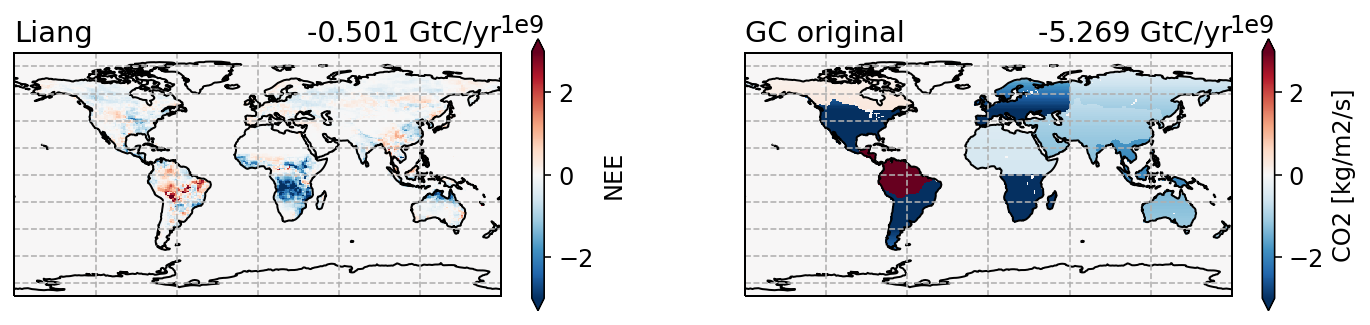

In [93]:
diff_total = (gc_total_liang - gc_total_original)#/gc_total_original

fig, axes = plt.subplots(1, 2, 
                         figsize=[12, 5], 
                         subplot_kw={'projection': ccrs.PlateCarree()})

format_total_liang = float("{0:.3f}".format(ann_total_C_liang))

gc_total_liang.plot(ax=axes[0], 
                    #transform=ccrs.PlateCarree(), 
                    vmax = 3e9, 
                    cbar_kwargs={'shrink': 0.5})
axes[0].set_title('Liang', loc='left')
axes[0].set_title(str(format_total_liang) + ' GtC/yr', loc = 'right')

format_total_original = float("{0:.3f}".format(ann_total_C_original))

gc_total_original.plot(ax=axes[1], 
                       #transform=ccrs.PlateCarree(), 
                       vmax = 3e9,
                       cbar_kwargs={'shrink': 0.5})
axes[1].set_title('GC original', loc='left')
axes[1].set_title(' ', loc = 'center')
axes[1].set_title(str(format_total_original) + ' GtC/yr', loc = 'right')

# Use for loop to save some coding. Useful when there are a lot of subplots.
for ax in axes:
    ax.coastlines()
    ax.gridlines(linestyle='--')


In [94]:
# Biosphere, SiB3 balanced Net Ecosystem Production (NEP) CO2
input_dir = '/geos/d21/GC_DATA/ExtData/HEMCO/'
fname = 'CO2/v2015-04/BIO/SiB3_3hr_NEP.nc'
ds_bio  = xr.open_dataset(input_dir+fname)

# year range: 2006 - 2010, get 2010 for this calculation
lat_res = ds_bio.attrs['Delta_Lat']
lon_res = ds_bio.attrs['Delta_Lon']
varname = 'CO2'
unit    = ds_bio[varname].attrs['units']
ds_bio

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 288, time: 14608)
Coordinates:
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * lat      (lat) float32 -89.75 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 89.75
  * time     (time) datetime64[ns] 2006-01-01 ... 2010-12-31T21:00:00
Data variables:
    CO2      (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.5.6 (http://code.zmaw.de/p...
    Conventions:  COARDS
    Title:        COARDS/netCDF file created by BPCH2COARDS (GAMAP v2-03+)
    Model:        GEOS5
    Delta_Lon:    1.25
    Delta_Lat:    1.0
    NLayers:      1
    Start_Date:   20060101
    Start_Time:   0
    End_Date:     20101231
    End_Time:     21
    Delta_Time:   3
    CDO:          Climate Data Operators version 1.5.6.1 (http://code.zmaw.de...
    history:      Fri Apr 17 10:38:06 2015: ncatted -a axis,time,o,c,T SiB3_3...

In [95]:
# year 2008 data, note it is leap year
begin = 2*8*365
end   = 3*8*365 + 8
data = ds_bio[varname][begin:end,:,:].copy()
np.shape(data)

(2928, 181, 288)

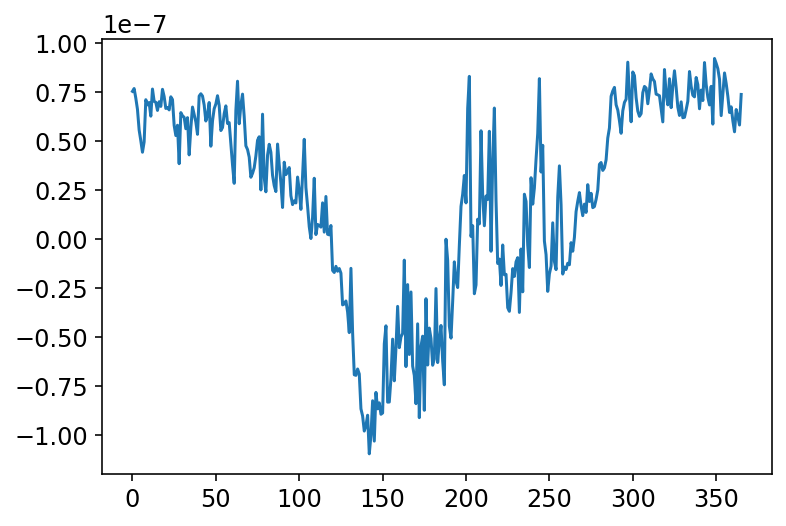

In [96]:
# a location in US, Mark Twain National Forest 
# 37.6876° N, 91.0828° W
ts_us = data.sel(lon = -91, lat = 37.7, method = 'nearest')
#plt.plot(ts_us[0:16])
ts_daily  = np.zeros(366) # store daily mean

for iday in range(366):
    ts_daily[iday] = np.mean(ts_us[(iday*8):((iday+1)*8-1)])
plt.plot(ts_daily)


In [97]:
# calculate global total emission
#area_lat = np.zeros(len(data.lat))
for ilat, lat in enumerate(data.lat):
    area_tmp = area_latlon(lat1 = lat, 
                            lon1 = data.lon[10].values, 
                            lat2 = lat + lat_res, 
                            lon2 = data.lon[10].values + lon_res)
    #area_lat[ilat] = area_tmp.values
    data[:,ilat,:] = data[:,ilat,:]*area_tmp.values*3*3600*1e6 # unit: kgCO2/3hours
gc_total_sib = data.sum(dim = 'time')          # kgCO2/year, same as data description
annual_total = gc_total_sib.sum()
ann_total_sib = annual_total.values*1e-12*12/44 # GtC/yr
#plt.plot(data.lat, area_lat)   
print('annual total from this calculation (GtC/yr):')
print(ann_total_sib)

annual total from this calculation (GtC/yr):
-0.0454582897570909


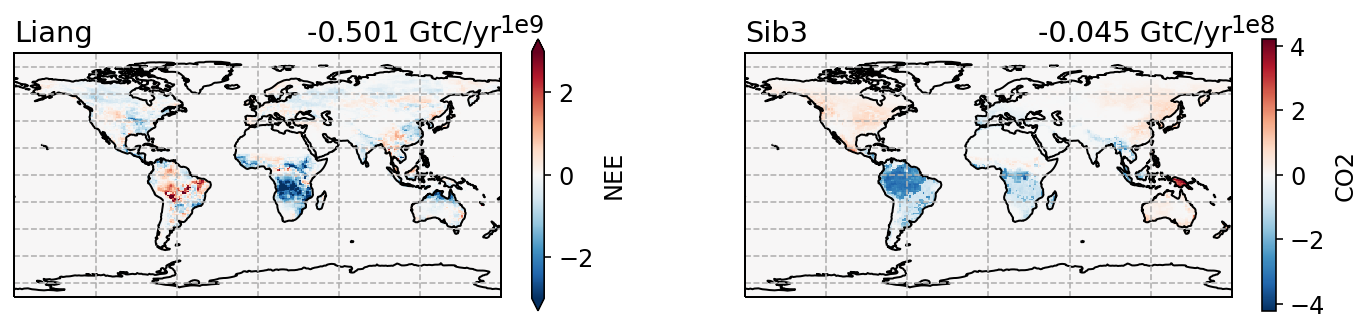

In [98]:

fig, axes = plt.subplots(1, 2, 
                         figsize=[12, 5], 
                         subplot_kw={'projection': ccrs.PlateCarree()})

gc_total_liang.plot(ax=axes[0], 
                    #transform=ccrs.PlateCarree(), 
                    vmax = 3e9, 
                    cbar_kwargs={'shrink': 0.5})
axes[0].set_title('Liang', loc='left')
axes[0].set_title(str(format_total_liang) + ' GtC/yr', loc = 'right')

format_total_sib = float("{0:.3f}".format(ann_total_sib))

gc_total_sib.plot(ax=axes[1], 
                       #transform=ccrs.PlateCarree(), 
                       #vmax = 3e9,
                       cbar_kwargs={'shrink': 0.5})
axes[1].set_title('Sib3', loc='left')
axes[1].set_title(str(format_total_sib) + ' GtC/yr', loc = 'right')

# Use for loop to save some coding. Useful when there are a lot of subplots.
for ax in axes:
    ax.coastlines()
    ax.gridlines(linestyle='--')


In [99]:
# convert Liang's file format to match GEOS-Chem input
time1 = ds_bio.time[begin:end].values[1]
time2 = np.datetime64('2016-01-01T03:00:00.000000000')
diff = time2 - time1
time = ds_bio.time[begin:end].values + diff
time # time dimension of output data

array(['2016-01-01T00:00:00.000000000', '2016-01-01T03:00:00.000000000',
       '2016-01-01T06:00:00.000000000', ...,
       '2016-12-31T15:00:00.000000000', '2016-12-31T18:00:00.000000000',
       '2016-12-31T21:00:00.000000000'], dtype='datetime64[ns]')

In [100]:
foo = xr.DataArray(0., coords=[time, data.lat, data.lon], dims=['time', 'lat', 'lon'])
foo.values = ds_liang['NEE'].values
output = foo.to_dataset(name = 'CO2')
output['CO2'].attrs = ds_bio['CO2'].attrs
output.attrs = ds_bio.attrs
output.attrs['Start_Date'] = '20160101'
output.attrs['End_Date'] = '20161231'
output.attrs['history'] = 'Processed by Mehliyar Sadiq, Apr 2020'

In [101]:
output.to_netcdf('/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2020-04/NEE.Liang.2016.nc')